In [1]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
1.15.2


In [4]:
!gdown --id 1MZTQ7ck5jVrLPjARFp-psocaZFlb4zJi
!gdown --id 1eWD8WaQcgWIwcOTEJA39Q6MN2PXdrSsC

Downloading...
From: https://drive.google.com/uc?id=1MZTQ7ck5jVrLPjARFp-psocaZFlb4zJi
To: /content/all_images.zip
321MB [00:03, 95.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eWD8WaQcgWIwcOTEJA39Q6MN2PXdrSsC
To: /content/annotation.zip
100% 237k/237k [00:00<00:00, 87.2MB/s]


In [5]:
!unzip -q /content/all_images.zip
!unzip -q /content/annotation.zip

In [6]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 45984, done.
remote: Total 45984 (delta 0), reused 0 (delta 0), pack-reused 45984
Receiving objects: 100% (45984/45984), 551.02 MiB | 36.28 MiB/s, done.
Resolving deltas: 100% (31532/31532), done.


In [7]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install tf-slim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 21 not upgraded.
Need to get 1,791 kB of archives.
After this operation, 7,807 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

In [8]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

/content/models/research


In [9]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/:/content/models/research/object_detection'

In [10]:
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/model_lib_v2.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph.py -> build/lib/object_detection
copying object_detection/inputs_test.py -> build/lib/object_detection
copying object_detection/model_main.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib_tf1_test.py -> build/lib/object_detection
copying object_detection/export_tflite_graph_lib_tf2.py -> build/lib/object_detection
copying object_detection/model_main_tf2.py -> build/lib/object_detection
copying object_detection/exporter_tf1_test.py -> build/lib/object_detection
copying object_detection/exporter_lib_tf2_test.py -> build/lib/object_detection
copying object_detection/model_lib_tf2_test.py -> build/lib/object_detection
copying object_detection/export_tf

In [11]:
#rember the last CD you did in order to specify the directory.
%cd /content/models/research/object_detection/builders/
!python model_builder_test.py

/content/models/research/object_detection/builders


In [12]:
%cd /content/models/research/object_detection

/content/models/research/object_detection


In [13]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
def main():
    # for Image_cat in directory_list:
    image_path = '/content/annotation'# os.path.join(os.getcwd(), 'images/{}'.format(Image_cat))
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('data/train_labels.csv', index=None)
    print('Successfully converted xml to csv.')
main()

Successfully converted xml to csv.


In [14]:
%pwd

'/content/models/research/object_detection'

In [15]:
%mkdir /content/colored_images

In [17]:
from tqdm import tqdm
import cv2
import numpy as np
image_source_path = '/content/all_images/*.bmp'
for image in tqdm(glob.glob(image_source_path)):
    img = cv2.imread(image)
    img = cv2.applyColorMap(img, cv2.COLORMAP_TWILIGHT_SHIFTED)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Threshold of blue in HSV space
    lower_blue = np.array([0, 0, 0])
    upper_blue = np.array([179, 130, 255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    img = cv2.bitwise_and(img, img, mask = mask)

    cv2.imwrite(f'/content/colored_images/{image.split("/")[-1]}', img)

100%|██████████| 384/384 [00:06<00:00, 56.42it/s]


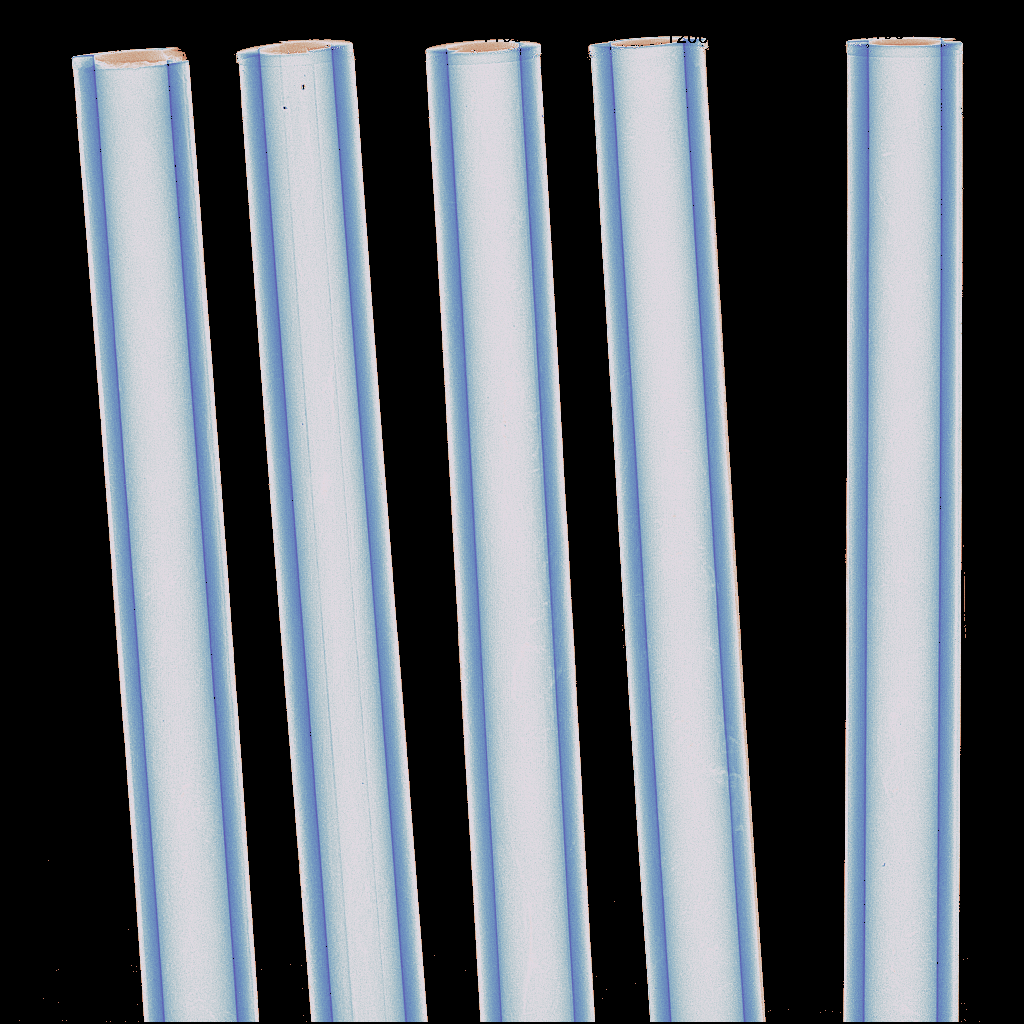

In [21]:
from PIL import Image
import glob
Image.open(glob.glob('/content/colored_images/*.bmp')[200])

In [22]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving generate_tfrecord.py to generate_tfrecord.py
Saving ssd_mobilenet_v1_coco.config to ssd_mobilenet_v1_coco.config
Saving train.py to train.py
User uploaded file "generate_tfrecord.py" with length 3565 bytes
User uploaded file "ssd_mobilenet_v1_coco.config" with length 5201 bytes
User uploaded file "train.py" with length 7068 bytes


In [23]:
!python3 generate_tfrecord.py --csv_input=data/train_labels.csv --output_path=data/train.record --image_dir=/content/colored_images/



W1019 11:14:26.134607 140166271698816 module_wrapper.py:139] From generate_tfrecord.py:89: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1019 11:14:26.200494 140166271698816 module_wrapper.py:139] From generate_tfrecord.py:48: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/models/research/object_detection/data/train.record


In [24]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
!tar -xvf ssd_mobilenet_v1_coco_11_06_2017.tar.gz

--2020-10-19 11:14:30--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.20.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128048406 (122M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz’

ssd_mobilenet_v1_co 100%[===================>] 122.12M   212MB/s    in 0.6s    

2020-10-19 11:14:31 (212 MB/s) - ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz’ saved [128048406/128048406]

ssd_mobilenet_v1_coco_11_06_2017/
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.index
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.meta
ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_11_06_2017/graph.pbtxt


In [25]:
%mkdir training
!touch training/object-detection.pbtxt
"""
item {
  id: 1
  name: 'FO'
}
item {
  id: 2
  name: 'CR'
}
item {
  id: 3
  name: 'NH'
}
"""

"\nitem {\n  id: 1\n  name: 'FO'\n}\nitem {\n  id: 2\n  name: 'CR'\n}\nitem {\n  id: 3\n  name: 'NH'\n}\n"

In [26]:
#downlaoding ngrok to be able to access tensorboard on google colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-10-19 11:15:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.214.245.1, 52.21.175.83, 52.44.17.83, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.214.245.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  17.5MB/s    in 0.7s    

2020-10-19 11:15:31 (17.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [27]:
#the logs that are created while training 
LOG_DIR = 'training/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [28]:
#The link to tensorboard.
#works after the training starts.

### note: if you didnt get a link as output, rerun this cell and the one above
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://3d7c5afc860e.ngrok.io


In [29]:
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=ssd_mobilenet_v1_coco.config

Streaming output truncated to the last 5000 lines.
INFO:tensorflow:global step 19308: loss = 10.7569 (0.166 sec/step)
I1019 12:37:40.315049 140682287880064 learning.py:512] global step 19308: loss = 10.7569 (0.166 sec/step)
INFO:tensorflow:global step 19309: loss = 8.2753 (0.510 sec/step)
I1019 12:37:40.826221 140682287880064 learning.py:512] global step 19309: loss = 8.2753 (0.510 sec/step)
INFO:tensorflow:global step 19310: loss = 10.0355 (0.167 sec/step)
I1019 12:37:40.994832 140682287880064 learning.py:512] global step 19310: loss = 10.0355 (0.167 sec/step)
INFO:tensorflow:global step 19311: loss = 9.6163 (0.437 sec/step)
I1019 12:37:41.433670 140682287880064 learning.py:512] global step 19311: loss = 9.6163 (0.437 sec/step)
INFO:tensorflow:global step 19312: loss = 9.9217 (0.360 sec/step)
I1019 12:37:41.795789 140682287880064 learning.py:512] global step 19312: loss = 9.9217 (0.360 sec/step)
INFO:tensorflow:global step 19313: loss = 7.4763 (0.217 sec/step)
I1019 12:37:42.014466 14

In [30]:
%pwd

'/content/models/research/object_detection'

In [31]:
%mkdir trained_inference_graph

In [32]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix training/model.ckpt-21111 --output_directory trained_inference_graph/

Instructions for updating:
Please use `layer.__call__` method instead.
W1019 12:49:32.565342 139980673140608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I1019 12:49:34.086863 139980673140608 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1019 12:49:34.127082 139980673140608 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I1019 12:49:34.163875 139980673140608 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [39]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util



### Model preparation variable
MODEL_NAME = 'trained_inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/object-detection.pbtxt'
NUM_CLASSES = 1 #remember number of objects you are training? cool.


### Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


###Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)




### Load image into numpy function
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




###STATING THE PATH TO IMAGES TO BE TESTED
PATH_TO_TEST_IMAGES_DIR = '/content/colored_images/'
TEST_IMAGE_PATHS = glob.glob('/content/colored_images/*.bmp')
IMAGE_SIZE = (12, 8)




### Function to run inference on a single image which will later be used in an iteration
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict



### To iterate on each image in the test image path defined 
### NB define the range of numbers and let it match the number of imAGES IN TEST FOLDER +1
for image_path in tqdm(TEST_IMAGE_PATHS):
    image = Image.open(image_path)
    original_image = Image.open(f'/content/all_images/{image_path.split("/")[-1]}')
    # print(f'/content/all_images/{image_path.split("/")[-1]}')
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    or_image_np = load_image_into_numpy_array(original_image)

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        or_image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=1,
        min_score_thresh=0.2)
    Image.fromarray(or_image_np).save(f'/content/test_results/{image_path.split("/")[-1]}')
    # display(Image.fromarray(or_image_np))

100%|██████████| 384/384 [17:01<00:00,  2.66s/it]


In [38]:
%mkdir /content/test_results

In [40]:
!zip -r /content/test_results.zip /content/test_results
from google.colab import files
files.download("/content/test_results.zip")

  adding: content/test_results/ (stored 0%)
  adding: content/test_results/1232-1233-1234-1235_003.bmp (deflated 72%)
  adding: content/test_results/1365-1367-1368-1369_003.bmp (deflated 72%)
  adding: content/test_results/1519-1520-1521_002.bmp (deflated 73%)
  adding: content/test_results/1641-1642-1643_001.bmp (deflated 74%)
  adding: content/test_results/1630-1617-1631_004.bmp (deflated 73%)
  adding: content/test_results/1623-1609-1620-1614_003.bmp (deflated 72%)
  adding: content/test_results/1659-1660-1661-1662_004.bmp (deflated 71%)
  adding: content/test_results/2010-2011-2013-2014_002.bmp (deflated 73%)
  adding: content/test_results/1575-1576-1577-1578_001.bmp (deflated 72%)
  adding: content/test_results/1684-1668-1685-1686_001.bmp (deflated 72%)
  adding: content/test_results/852-853-854-855_003.bmp (deflated 72%)
  adding: content/test_results/1623-1609-1620-1614_004.bmp (deflated 71%)
  adding: content/test_results/2396-2395-2394-2393_004.bmp (deflated 72%)
  adding: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
!scp /content/test_results.zip '/content/drive/My Drive/wakeb/power_pipes/'

In [37]:
!zip -r ./training/latest_training_7.zip ./2_trained_inference_graph

  adding: 2_trained_inference_graph/ (stored 0%)
  adding: 2_trained_inference_graph/model.ckpt.meta (deflated 94%)
  adding: 2_trained_inference_graph/model.ckpt.index (deflated 68%)
  adding: 2_trained_inference_graph/checkpoint (deflated 42%)
  adding: 2_trained_inference_graph/model.ckpt.data-00000-of-00001 (deflated 7%)
  adding: 2_trained_inference_graph/saved_model/ (stored 0%)
  adding: 2_trained_inference_graph/saved_model/variables/ (stored 0%)
  adding: 2_trained_inference_graph/saved_model/saved_model.pb (deflated 9%)
  adding: 2_trained_inference_graph/pipeline.config (deflated 69%)
  adding: 2_trained_inference_graph/frozen_inference_graph.pb (deflated 9%)


In [38]:
!scp /content/models/research/object_detection/training/latest_training_7.zip '/content/drive/My Drive/wakeb/power_pipes/'

In [ ]:
import glob
glob.glob('/content/all_images/*.bmp')[:4]

In [ ]:
!zip  trained_infrance_graph

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/models/research/object_detection/data/train_labels.csv')
df.head()

In [ ]:
df[~df['class'].isin(['FO','CR','NH'])]